In [1]:
import figure_Tbasis as fb
import targeted_basis as tb
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from figure_properties import *
import os
from sklearn import preprocessing
from kcsd import oKCSD1D

In [2]:
def calculate_eigensources(obj):        
    try:
        eigenvalue, eigenvector = np.linalg.eigh(obj.k_pot +
                                                 obj.lambd *
                                                 np.identity
                                                 (obj.k_pot.shape[0]))
        print('lambd: ', obj.lambd)
    except LinAlgError:
        raise LinAlgError('EVD is failing - try moving the electrodes'
                          'slightly')
    idx = eigenvalue.argsort()[::-1]
    eigenvalues = eigenvalue[idx]
    eigenvectors = eigenvector[:, idx]
    eigensources = np.dot(obj.k_interp_cross, eigenvectors)
    eigensources = preprocessing.normalize(eigensources, axis=0)
    return eigensources

In [3]:
def _html(r, g, b):
    return "#{:02X}{:02X}{:02X}".format(r, g, b)

In [4]:
def make_subplot(ax, eigensources, estm_x, title=None, ele_pos=None,
                 xlabel=False, ylabel=False, letter='', t_max=None):
    BLACK = _html(0, 0, 0)
    ORANGE = _html(230, 159, 0)
    SKY_BLUE = _html(86, 180, 233)
    GREEN = _html(0, 158, 115)
    YELLOW = _html(240, 228, 66)
    BLUE = _html(0, 114, 178)
    VERMILION = _html(213, 94, 0)
    PURPLE = _html(204, 121, 167)
    colors = [GREEN, PURPLE, VERMILION, ORANGE, SKY_BLUE, YELLOW, BLUE, BLACK]
    for i in range(6):
        l1 = ax.plot(estm_x, eigensources[:, i], color=colors[i], lw=2., label='Eigensource ' + str(i+1))
    ax.set_xlim([0, 1])
    if xlabel:
        ax.set_xlabel('Depth ($mm$)')
    if ylabel:
        ax.set_ylabel('CSD ($mA/mm$)')
    if title is not None:
        ax.set_title(title, fontsize=20)
    ax.set_xticks([0, 0.5, 1])
    fb.set_axis(ax, letter=letter)
    # ax.legend(frameon=False, loc='upper center', ncol=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

In [5]:
def csd_into_eigensource_projection(csd, eigensources):
    orthn = scipy.linalg.orth(eigensources)
    return np.matmul(np.matmul(csd, orthn), orthn.T)

In [6]:
def plot_projection(ax, true_projection, est_projection, estm_x, title=None, ele_pos=None,
                 xlabel=False, ylabel=False, letter='', t_max=None,
                 est_csd_LC=None, c='b', label='Projection', diff=None):

    x = np.linspace(0, 1, 100)
    l1 = ax.plot(estm_x, true_projection, color=c, label=label + ' True CSD', lw=2.)
    if est_projection is not None:
        l2 = ax.plot(estm_x, est_projection, '--', color=c, label=label + ' kCSD', lw=2.)
    if diff is not None:
        l3 = ax.plot(estm_x, diff, '-.', color='Gray', label='True CSD - kCSD', lw=2.)
    #if est_csd_LC is not None:
    #    l2 = ax.plot(estm_x, est_csd, '--', label='kCSD Cross-validation', lw=2.)
    #    l3 = ax.plot(estm_x, est_csd_LC, '.', label='kCSD L-Curve', lw=2.)
    #else:
    #    l2 = ax.plot(estm_x, est_csd, '--', label='kCSD', lw=2.)
    est_csd = true_projection
    ax.set_xlim([0, 1])
    if xlabel:
        ax.set_xlabel('Depth ($mm$)', fontsize=18)
    if ylabel:
        ax.set_ylabel('CSD ($mA/mm$)', fontsize=18)
    if title is not None:
        ax.set_title(title, fontsize=20)
    if np.max(est_csd) < 1.2:
        ax.set_ylim(-0.2, 1.2)
        s1 = ax.scatter(ele_pos, np.zeros(len(ele_pos))-0.2, 17, 'k')
        s1.set_clip_on(False)
    elif np.max(est_csd) < 1.7:
        ax.set_ylim(-10000, 10000)
        s3 = ax.scatter(ele_pos, np.zeros(len(ele_pos))-10000, 17, 'k')
        s3.set_clip_on(False)
        ax.set_yticks([-7000, 0, 7000])
    if np.max(est_csd) > 500:
        ax.set_ylim(-7000, 7000)
        s3 = ax.scatter(ele_pos, np.zeros(len(ele_pos))-7000, 17, 'k')
        s3.set_clip_on(False)
        ax.set_yticks([-5000, 0, 5000])
    elif np.max(est_csd) > 50:
        ax.set_ylim(-100, 100)
        s2 = ax.scatter(ele_pos, np.zeros(len(ele_pos))-100, 17, 'k')
        s2.set_clip_on(False)
        ax.set_yticks([-70, 0, 70])
    ax.set_xticks([0, 0.5, 1])
    fb.set_axis(ax, letter=letter)
    # ax.legend(frameon=False, loc='upper center', ncol=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

In [7]:
def modified_bases(val, pots, ele_pos, n_src, own_est, own_src, title=None, h=0.25, sigma=0.3,
                   R=0.2, MU=0.25,
                   method='cross-validation', Rs=None, lambdas=None):
    '''
    Parameters
    ----------
    val: object of the class ValidateKCSD1D
    pots: numpy array
        Potentials measured (calculated) on electrodes.
    ele_pos: numpy array
        Locations of electrodes.
    n_src: int
        Number of basis sources.
    title: string
        Title of the plot.
    h: float
        Thickness of analyzed cylindrical slice.
        Default: 0.25.
    sigma: float
        Space conductance of the medium.
        Default: 0.3.
    gdx: float
        Space increments in the estimation space.
        Default: 0.035.
    ext_x: float
        Length of space extension: xmin-ext_x ... xmax+ext_x.
        Default: 0.
    xmin: float
        Boundaries for CSD estimation space.
    xmax: float
        boundaries for CSD estimation space.
    R: float
        Thickness of the groundtruth source.
        Default: 0.2.
    MU: float
        Central position of Gaussian source
        Default: 0.25.
    method: string
        Determines the method of regularization.
        Default: cross-validation.
    Rs: numpy 1D array
        Basis source parameter for crossvalidation.
        Default: None.
    lambdas: numpy 1D array
        Regularization parameter for crossvalidation.
        Default: None.

    Returns
    -------
    obj_m: object of the class oKCSD1D
    '''
    pots = pots.reshape((len(ele_pos), 1))
    obj_m = oKCSD1D(ele_pos, pots, src_type='gauss', sigma=sigma, h=h,
                   n_src_init=n_src, own_est=own_est, own_src=own_src)
    if method == 'cross-validation':
        obj_m.cross_validate(Rs=Rs, lambdas=lambdas)
    elif method == 'L-curve':
        obj_m.L_curve(Rs=Rs, lambdas=lambdas)
    est_csd = obj_m.values('CSD')
    test_csd = tb.csd_profile(own_est, [R, MU])
    rms = val.calculate_rms(test_csd, est_csd)
#    titl = "Lambda: %0.2E; R: %0.2f; RMS_Error: %0.2E;" % (obj_m.lambd,
#                                                           obj_m.R, rms)
#    fig = k.make_plot(csd_at, true_csd, obj_m, est_csd, ele_pos, pots, titl)
#    save_as = (SAVE_PATH)
#    fig.savefig(os.path.join(SAVE_PATH, save_as + '/' + title + '.png'))
#    plt.close()
#    ss = SpectralStructure(obj_m)
#    eigenvectors, eigenvalues = ss.evd()
    return obj_m

In [8]:
def csd_profile(x, seed):
    '''Function used for adding multiple 1D gaussians.

    Parameters
    ----------
    x: numpy array
        x coordinates of true source profile.
    seed: list [r, mu]

    Returns
    -------
    gauss: numpy array
        Gaussian profile for given R and M.
    '''
    r = seed[0]
    mu = seed[1]
    STDDEV = r/3.0
    gauss = (np.exp(-((x - mu)**2)/(2 * STDDEV**2)) /
             (np.sqrt(2 * np.pi) * STDDEV)**1)
    gauss /= np.max(gauss)
    #gauss = np.array([gauss[i]*0.125] for i in range(len(x)))
    return gauss

In [9]:
def generate_figure_projection(R, MU, n_src, true_csd_xlims, total_ele,
                    method='cross-validation', Rs=None, lambdas=None,
                    noise=0):
    """
    Generates figure for targeted basis investigation.

    Parameters
    ----------
    R: float
        Thickness of the groundtruth source.
        Default: 0.2.
    MU: float
        Central position of Gaussian source
        Default: 0.25.
    nr_src: int
        Number of basis sources.
    true_csd_xlims: list
        Boundaries for ground truth space.
    total_ele: int
        Number of electrodes.
    save_path: string
        Directory.
    method: string
        Determines the method of regularization.
        Default: cross-validation.
    Rs: numpy 1D array
        Basis source parameter for crossvalidation.
        Default: None.
    lambdas: numpy 1D array
        Regularization parameter for crossvalidation.
        Default: None.
    noise: float
        Determines the level of noise in the data.
        Default: 0.

    Returns
    -------
    None
    """
    true_csd_projection = tb.csd_profile(np.linspace(0, 1, 100), [R, MU])
    ele_lims = [0, 0.5]
    csd_at, true_csd, ele_pos, pots, val = tb.simulate_data(tb.csd_profile,
                                                            true_csd_xlims, R,
                                                            MU, total_ele,
                                                            ele_lims,
                                                            noise=noise)

    fig = plt.figure(figsize=(18, 15))
    widths = [1, 1, 1, 1]
    heights = [1, 1, 1]
    gs = gridspec.GridSpec(3, 4, height_ratios=heights, width_ratios=widths,
                           hspace=0.45, wspace=0.3)


    xmin = -0.5
    xmax = 1
    ext_x = -0.5
    own_est = np.linspace(0, 1, 100)
    own_src = np.linspace(0, 0.5, n_src)
    obj = modified_bases(val, pots, ele_pos, n_src, own_est, own_src, h=0.25,
                            sigma=0.3, method=method, Rs=Rs, lambdas=lambdas)
    obj_CV = modified_bases(val, pots, ele_pos, n_src, own_est, own_src, h=0.25,
                            sigma=0.3, method=method, Rs=Rs, lambdas=None)
    
    basis = np.array([csd_profile(np.linspace(0, 1, 100), [R, src_x]) for src_x in own_src]).T
    #basis[50:, :] = 0.
    basis = basis[:, ::9] - np.ones(basis[:, ::9].shape)*0.2
    print(basis.shape)
    
    ax = fig.add_subplot(gs[0, 0])
    fb.make_subplot(ax, true_csd, obj.values('CSD'), obj.estm_x, ele_pos=ele_pos,
                 title="CSD", xlabel=False, ylabel='well-placed electrodes \n \n', letter='A', basis=basis,
                   text_pos=[0.05, -0.06], est_csd_cv=obj_CV.values('CSD'))
    
    eigensources = calculate_eigensources(obj)
    for i in range(eigensources.shape[1]):
        mean = np.mean(eigensources[50:, i])
        if mean > 0:
            eigensources[:, i] = eigensources[:, i]
        else:
            eigensources[:, i] = - eigensources[:, i]
    projection = csd_into_eigensource_projection(true_csd_projection, eigensources)
    kcsd_projection = csd_into_eigensource_projection(obj.values('CSD')[:, 0], eigensources)
    annihilator = true_csd_projection - projection
    kcsd_annihilator = true_csd_projection - obj.values('CSD')[:, 0]
    #kcsd_annihilator = obj.values('CSD')[:, 0] - kcsd_projection
    
    ax = fig.add_subplot(gs[0, 1])
    plot_projection(ax, projection, None, obj.estm_x, ele_pos=ele_pos,
                    title='Projection', xlabel=False, ylabel=False, letter='B',
                    diff=None)
    
    ax = fig.add_subplot(gs[0, 2])
    plot_projection(ax, annihilator, None, obj.estm_x, ele_pos=ele_pos,
                    title='Annihilated and\nunaccounted for', xlabel=False, ylabel=False,
                    letter='C', c='r', label='Annihilated', diff=kcsd_annihilator)
    
    ax = fig.add_subplot(gs[0, 3])
    make_subplot(ax, eigensources, obj.estm_x, ele_pos=ele_pos,
                 title='Eigensources', xlabel=False, ylabel=False, letter='D')


    ele_lims = [0.5, 1]
    csd_at, true_csd, ele_pos, pots, val = tb.simulate_data(tb.csd_profile,
                                                            true_csd_xlims, R,
                                                            MU, total_ele,
                                                            ele_lims,
                                                            noise=noise)
    
    xmin = -0.5
    xmax = 1
    ext_x = -0.5
    own_est = np.linspace(0., 1., 100)
    own_src = np.linspace(0., 0.5, n_src)
    obj = modified_bases(val, pots, ele_pos, n_src, own_est, own_src, h=0.25,
                            sigma=0.3, method=method, Rs=Rs, lambdas=lambdas)
    obj_CV = modified_bases(val, pots, ele_pos, n_src, own_est, own_src, h=0.25,
                            sigma=0.3, method=method, Rs=Rs, lambdas=None)
    
    ax = fig.add_subplot(gs[2, 0])
    fb.make_subplot(ax, true_csd, obj.values('CSD'), obj.estm_x, ele_pos=ele_pos,
                 title=None, xlabel=True, ylabel='rescue analysis \n \n', letter='I', basis=basis,
                   text_pos=[0.05, -0.06], est_csd_cv=obj_CV.values('CSD'))
    
    eigensources = calculate_eigensources(obj)
    eigensources = calculate_eigensources(obj)
    for i in range(eigensources.shape[1]):
        mean = np.mean(eigensources[50:, i])
        if mean > 0:
            eigensources[:, i] = eigensources[:, i]
        else:
            eigensources[:, i] = - eigensources[:, i]
    projection = csd_into_eigensource_projection(true_csd_projection, eigensources)
    kcsd_projection = csd_into_eigensource_projection(obj.values('CSD')[:, 0], eigensources)
    annihilator = true_csd_projection - projection
    kcsd_annihilator = true_csd_projection - obj.values('CSD')[:, 0]
    #kcsd_annihilator = obj.values('CSD')[:, 0] - kcsd_projection
    
    ax = fig.add_subplot(gs[2, 1])
    plot_projection(ax, projection, None, obj.estm_x, ele_pos=ele_pos,
                 title=None, xlabel=True, ylabel=False, letter='J', diff=None)
    
    ax = fig.add_subplot(gs[2, 2])
    plot_projection(ax, annihilator, None, obj.estm_x, ele_pos=ele_pos,
                 title=None, xlabel=True, ylabel=False, letter='K', c='r', diff=kcsd_annihilator)
    
    ax = fig.add_subplot(gs[2, 3])
    make_subplot(ax, eigensources, obj.estm_x, ele_pos=ele_pos,
                 title=None, xlabel=True, ylabel=False, letter='L')

    
    true_csd_projection2 = tb.csd_profile(np.linspace(0, 1, 100), [R, MU])
    xmin = 0
    xmax = 1.5
    ext_x = -0.5
    own_est3 = np.linspace(0., 1., 100)
    own_src3 = np.linspace(0.5, 1., n_src)
    obj = modified_bases(val, pots, ele_pos, n_src, own_est3, own_src3, h=0.25,
                            sigma=0.3, method=method, Rs=Rs, lambdas=lambdas)
    obj_CV = modified_bases(val, pots, ele_pos, n_src, own_est3, own_src3, h=0.25,
                            sigma=0.3, method=method, Rs=Rs, lambdas=None)

    basis = np.array([tb.csd_profile(np.linspace(0, 1, 100), [R, src_x]) for src_x in own_src3]).T
    #basis[:49, :] = 0
    basis = basis[:, ::9] - np.ones(basis[:, ::9].shape)*0.2
    print(basis.shape)

    ax1 = fig.add_subplot(gs[1, 0])
    ax1 = fb.make_subplot(ax1, true_csd, obj.values('CSD'), obj.estm_x, ele_pos=ele_pos,
                 title=None, xlabel=False, ylabel='misplaced electrodes \n \n', letter='E', basis=basis,
                         text_pos=[0.55, -0.06], est_csd_cv=obj_CV.values('CSD'))
    
    eigensources = calculate_eigensources(obj)
    eigensources = calculate_eigensources(obj)
    for i in range(eigensources.shape[1]):
        mean = np.mean(eigensources[:49, i])
        if mean > 0:
            eigensources[:, i] = eigensources[:, i]
        else:
            eigensources[:, i] = - eigensources[:, i]
    projection = csd_into_eigensource_projection(true_csd_projection2, eigensources)
    kcsd_projection = csd_into_eigensource_projection(obj.values('CSD')[:, 0], eigensources)
    annihilator = true_csd_projection - projection
    kcsd_annihilator = true_csd_projection - obj.values('CSD')[:, 0]
    #kcsd_annihilator = obj.values('CSD')[:, 0] - kcsd_projection
    
    ax2 = fig.add_subplot(gs[1, 1])
    ax2 = plot_projection(ax2, projection, None, obj.estm_x, ele_pos=ele_pos,
                          title=None, xlabel=False, ylabel=False, letter='F', diff=None)
    
    ax3 = fig.add_subplot(gs[1, 2])
    ax3 = plot_projection(ax3, annihilator, None, obj.estm_x, ele_pos=ele_pos,
                 title=None, xlabel=False, ylabel=False, letter='G', c='r', label='Annihilated', diff=kcsd_annihilator)
    
    ax4 = fig.add_subplot(gs[1, 3])
    ax4 = make_subplot(ax4, eigensources, obj.estm_x,
                      ele_pos=ele_pos, title=None, xlabel=False, ylabel=False,
                      letter='H')
    
    handles, labels = [(a + b +c + d) for a, b, c, d in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels(),
                                                            ax3.get_legend_handles_labels(), ax4.get_legend_handles_labels())]
    
    #handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=6, frameon=False)

    fig.savefig(os.path.join('Projection_targeted_basis_noise_' + str(noise) + 'normalized2_oKCSD1D_changed_rows.png'), dpi=300)
    plt.show()

min lambda 1e-09
max lambda 0.0094
l-curve (all lambda):  0.2
Best lambda and R =  0.0 ,  0.2
No lambda given, using defaults
min lambda 1e-09
max lambda 0.0091
min lambda 1e-09
max lambda 0.0094
l-curve (all lambda):  0.2
Best lambda and R =  3.819826788095682e-08 ,  0.2
(100, 8)
lambd:  0.0
min lambda 1e-14
max lambda 0.0126
l-curve (all lambda):  0.2
Best lambda and R =  0.0 ,  0.2
No lambda given, using defaults
min lambda 1e-14
max lambda 0.0125
min lambda 1e-14
max lambda 0.0126
l-curve (all lambda):  0.2
Best lambda and R =  3.0809884623485004e-12 ,  0.2
lambd:  0.0
lambd:  0.0
min lambda 1e-09
max lambda 0.0094
l-curve (all lambda):  0.2
Best lambda and R =  0.0 ,  0.2
No lambda given, using defaults
min lambda 1e-09
max lambda 0.0091
min lambda 1e-09
max lambda 0.0094
l-curve (all lambda):  0.2
Best lambda and R =  1.4049016480029884e-09 ,  0.2
(100, 8)
lambd:  0.0
lambd:  0.0


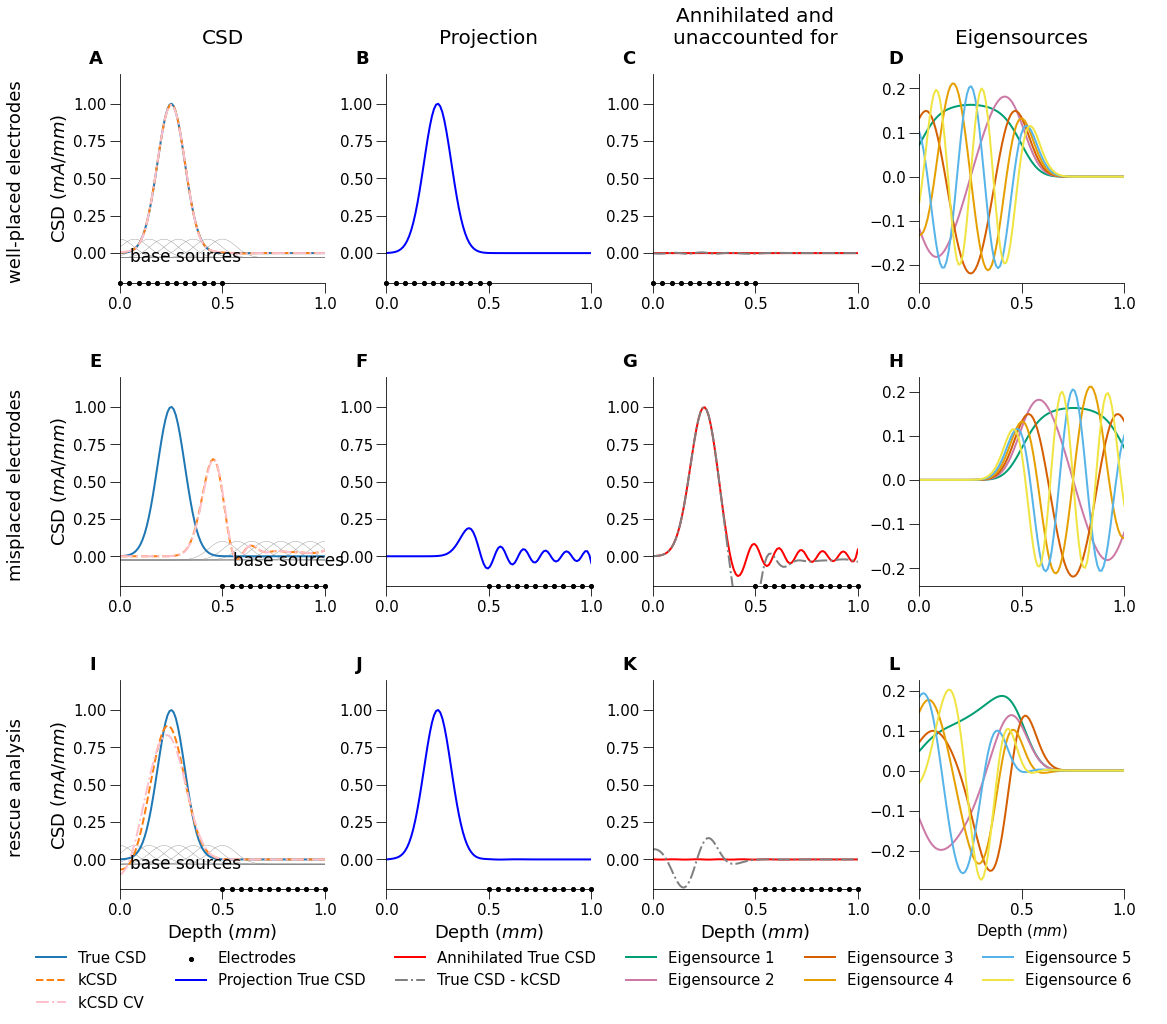

In [10]:
N_SRC = 64
TRUE_CSD_XLIMS = [0., 1.]
TOTAL_ELE = 12
R = 0.2
MU = 0.25
#method = 'cross-validation'  # L-curve
method = 'L-curve'
Rs = np.array([0.2])
lambdas = np.zeros(1)
generate_figure_projection(R, MU, N_SRC, TRUE_CSD_XLIMS, TOTAL_ELE,
                method=method, Rs=Rs, lambdas=lambdas, noise=0)